<div align="center">
    <div style="position: relative; max-width: 2500px; height: auto;">
        <img src="https://github.com/Kwack0202/VSCode_markdown_IMG/blob/main/earth-seen-from-space.jpg?raw=true" width="100%" style="border-radius:10px; max-height: 550px;">
        <div style="position: absolute; top: 50%; left: 50%; transform: translate(-50%, -50%); text-align: center; color: white; font-size: 60px; font-weight: bold; text-shadow: 2px 2px 4px #000;">
            <span style="padding: 10px; border-radius: 10px;">Satellite IMG Segmentation</span>
        </div>
    </div>
</div>

------------------------------------------
## Openmmlab 코드 실행 환경준비

#### **step 0.** 작업환경 확인 (C언어, 파이썬, VSC 등)
- C++이 설치되지 않으면 실행 오류남

#### **step 1.** 가상환경 생성
- conda create --name openmmlab python=3.8 -y
- conda activate openmmlab

#### **step 2.** 관련 패키지 생성 (프롬프트에서 설치)
- pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118
- pip install -U openmim
- mim install mmengine
- mim install "mmcv>=2.0.0"
- pip install wandb

#### **step 3.** MMsegmentation git 연결하기
`git bash 사용`
- **git clone -b main https://github.com/open-mmlab/mmsegmentation.git**

`anaconda prompt 사용`
- **cd C:\Users\coden\OneDrive\바탕 화면\Building\mmsegmentation**
- **pip install -v -e .** 

#### **step 4.** SegLocalVisualizer 코드 수정
    def __init__(self,
                 draw: bool = False,
                 interval: int = 50,
                 show: bool = False,
                 wait_time: float = 0.,
                 backend_args: Optional[dict] = None):
        self._visualizer: SegLocalVisualizer = SegLocalVisualizer.get_instance(name="Visualizer")
        self.interval = interval
        self.show = show

In [1]:
from common_imports import *
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu118 True


## PNG 파일을 제외하곤 폴더에서 제거

In [2]:
''' # Satellite_Data 경로 설정
base_path = './Satellite_Data'

# Buildings와 Roads 폴더의 경로
folders = ['Buildings', 'Roads']

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    
    # images라는 문자열이 포함된 폴더들 찾기
    image_folders = glob.glob(os.path.join(folder_path, '**/*images*'), recursive=True)
    
    for image_folder in image_folders:
        for file_name in os.listdir(image_folder):
            file_path = os.path.join(image_folder, file_name)
            
            # 파일이 png가 아닌 경우 삭제
            if not file_name.endswith('.png'):
                os.remove(file_path) '''

## Json 파일을 활용한 마스킹 이미지 생성하기

#### Roadmark annotation 분포 확인하기

In [ ]:
# 경로 설정
folder_path = './Roadmark/Json/'

# supercategory 분포를 저장할 딕셔너리 초기화
supercategory_distribution = defaultdict(int)

# JSON 파일 읽기 및 supercategory 분포 계산
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.json'):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            categories = {category['id']: category['supercategory'] for category in data['categories']}
            
            for annotation in data['annotations']:
                category_id = annotation['category_id']
                supercategory = categories.get(category_id, 'Unknown')
                supercategory_distribution[supercategory] += 1

# name, supercategory 분포를 빈도순으로 정렬
sorted_name_supercategory_distribution = sorted(supercategory_distribution.items(), key=lambda item: item[1], reverse=True)

In [5]:
# 결과 출력
for supercategory, count in sorted_name_supercategory_distribution:
    print(f'{supercategory}: {count}')

roadlane: 172578
direction: 78247
guidance: 21242
etc: 11324
speed_restriction: 5963
roadlane_ban: 2153
direction_ban: 282
stop_lane: 279
direction_guidance: 196
crosswalk: 134
protection_zone: 28


In [8]:
# name 분포를 저장할 딕셔너리 초기화
name_supercategory_distribution = defaultdict(int)

# JSON 파일 읽기 및 name, supercategory 분포 계산
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.json'):
        with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            categories = {category['id']: (category['name'], category['supercategory']) for category in data['categories']}
            
            for annotation in data['annotations']:
                category_id = annotation['category_id']
                name, supercategory = categories.get(category_id, ('Unknown', 'Unknown'))
                name_supercategory_distribution[(name, supercategory)] += 1

# name, supercategory 분포를 빈도순으로 정렬
sorted_name_supercategory_distribution = sorted(name_supercategory_distribution.items(), key=lambda item: item[1], reverse=True)

# 결과 출력
for (name, supercategory), count in sorted_name_supercategory_distribution:
    print(f'{name} ({supercategory}): {count}')

100%|██████████| 37714/37714 [00:19<00:00, 1951.43it/s]

차선 (roadlane): 68011
길가장자리구역선 (roadlane): 64247
진행방향 및 방면540 (direction): 35118
진행방향537 (direction): 27579
진로변경제한선507 (roadlane): 23028
노면색깔유도선 (guidance): 20984
진행방향 및 방면541 (direction): 11907
안전지대 (etc): 9530
진로변경제한선506 (roadlane): 7661
속도제한 (speed_restriction): 5949
중앙선 (roadlane): 5732
버스전용차로 (roadlane): 3372
차로변경 (direction): 2337
정차주차금지516 (roadlane_ban): 1406
진행방향538 (direction): 1203
양보 (etc): 784
정차주차금지5162 (roadlane_ban): 712
서행519 (etc): 654
진로변경제한선508 (roadlane): 449
정지선 (stop_lane): 279
유도선 (guidance): 258
횡단보도예고 (direction_guidance): 193
과속방지턱 (etc): 168
정차금지지대 (etc): 150
직진금지 (direction_ban): 133
횡단보도 (crosswalk): 126
우회전금지 (direction_ban): 106
진행방향539 (direction): 103
유턴구역선 (roadlane): 78
주차금지 (roadlane_ban): 35
주차 (etc): 33
유턴금지 (direction_ban): 27
노인보호구역 (protection_zone): 27
좌회전금지 (direction_ban): 15
속도제한어린이보호구역 (speed_restriction): 14
고원식횡단보도 (crosswalk): 8
서행520 (etc): 3
일시정지 (etc): 2
회전교차로양보선표시 (direction_guidance): 2
좌우회전금지 (direction_ban): 1
유도527 (direction_gui

#### Annotation 클래스ID 고유번호 지정

In [2]:
# 각 supercategory별로 색상 지정 (RGB 형태)
colors = {
    'background' : (0, 0, 0),
                 
    'roadlane': (255, 255, 255),         
         
    'guidance': (0, 128, 0),
    
    'direction': (255, 105, 180),              

    'etc': (128, 0, 128),
    
    'speed_restriction': (255, 0, 0)                              
}

# 색상 -> ID 매핑 함수
def clr2id(clr):
    return clr[0] + clr[1] * 255 + clr[2] * 255 * 255

id_tab = {k: clr2id(v) for k, v in colors.items()}
id_tab # 클래스 라벨 별 고유 iD생성

{'background': 0,
 'roadlane': 16646655,
 'guidance': 32640,
 'direction': 11731530,
 'etc': 8323328,
 'speed_restriction': 255}

In [4]:
def transform(label, dtype=np.int32):
    height, width = label.shape[:2]
    newLabel = np.zeros((height, width), dtype=dtype)
    id_label = label.astype(np.int64)
    id_label = id_label[:, :, 0] + id_label[:, :, 1] * 255 + id_label[:, :, 2] * 255 * 255
    for tid, val in enumerate(id_tab.values()):
        mask = (id_label == val)
        newLabel[mask] = tid
    return newLabel

In [5]:
# JSON 파일이 저장된 폴더 경로
json_folder_path = './Roadmark/Json/'
output_folder_path = './Roadmark/Masked_Images/'
label_output_folder_path = './Roadmark/Labels/'

In [6]:
# JSON 파일 목록 가져오기
json_file_list = [f for f in os.listdir(json_folder_path) if f.endswith('.json')]

# 출력 폴더가 없으면 생성
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

if not os.path.exists(label_output_folder_path):
    os.makedirs(label_output_folder_path)

In [10]:
# 제외할 슈퍼카테고리 목록
exclude_supercategories = {'roadlane_ban', 'direction_ban', 'stop_lane', 'direction_guidance', 'crosswalk', 'protection_zone'}

# json 파일 목록
json_file_list = os.listdir(json_folder_path)

In [11]:
def process_json(json_file_name):
    try:
        filename = json_file_name[:-5]  # 파일 이름 지정 (확장자 제거)
        with open(os.path.join(json_folder_path, json_file_name), 'r', encoding='utf-8') as f:
            data = json.load(f)

        polylines = []
        segmeatations = []
        supercategories_poly = []
        supercategories_seg = []

        # annotation 정보에서 polyline 추출
        for ann in data['annotations']:
            try:
                polyline = ann['polyline']
                category_id = ann['category_id']
                supercategory = next(cat['supercategory'] for cat in data['categories'] if cat['id'] == category_id)
                if supercategory not in exclude_supercategories:
                    polylines.append(polyline)
                    supercategories_poly.append(supercategory)
            except KeyError:
                pass

        # annotation 정보에서 segmentation 추출
        for ann in data['annotations']:
            try:
                segmeatation = ann['segmentation']
                category_id = ann['category_id']
                supercategory = next(cat['supercategory'] for cat in data['categories'] if cat['id'] == category_id)
                if supercategory not in exclude_supercategories:
                    segmeatations.append(segmeatation)
                    supercategories_seg.append(supercategory)
            except KeyError:
                pass

        # 검은색 배경 이미지 생성
        width = data['images'][0]['width']
        height = data['images'][0]['height']
        img = Image.new('RGB', (width, height), color='black')
        draw = ImageDraw.Draw(img)

        # polyline 그리기
        for lines, supercat in zip(polylines, supercategories_poly):
            color = colors[supercat]
            for line in lines:
                # line 리스트의 좌표를 튜플로 변환
                points = [(line[i], line[i+1]) for i in range(0, len(line), 2)]
                draw.line(points, fill=color, width=4)

        # segmentation 그리기
        # direction supercategory를 제외한 다른 supercategory 그리기
        for lines, supercat in zip(segmeatations, supercategories_seg):
            if supercat == 'direction':
                continue  # direction은 나중에 그리기 위해 건너뜀
            color = colors[supercat]
            for line in lines:
                # line 리스트의 좌표를 튜플로 변환
                points = [(line[i], line[i+1]) for i in range(0, len(line), 2)]
                draw.polygon(points, fill=color, outline=color)

        # direction supercategory 그리기
        for lines, supercat in zip(segmeatations, supercategories_seg):
            if supercat != 'direction':
                continue  # direction만 그리기 위해 건너뜀
            color = colors[supercat]
            for line in lines:
                # line 리스트의 좌표를 튜플로 변환
                points = [(line[i], line[i+1]) for i in range(0, len(line), 2)]
                draw.polygon(points, fill=color, outline=color)

        # 마스킹 이미지 저장
        mask_image_path = os.path.join(output_folder_path, filename + '_mask.png')
        img.save(mask_image_path)

        # 마스킹 이미지를 클래스 인덱스 이미지로 변환하여 저장
        gt = np.array(img)
        trainId = transform(gt, dtype=np.uint8)
        label_image_path = os.path.join(label_output_folder_path, filename + '_label.png')
        Image.fromarray(trainId).save(label_image_path)
    except Exception as e:
        print(f"Failed to process {json_file_name}: {e}")

# 병렬 처리
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(process_json, json_file_list), total=len(json_file_list)))

100%|██████████| 37714/37714 [29:49<00:00, 21.07it/s] 


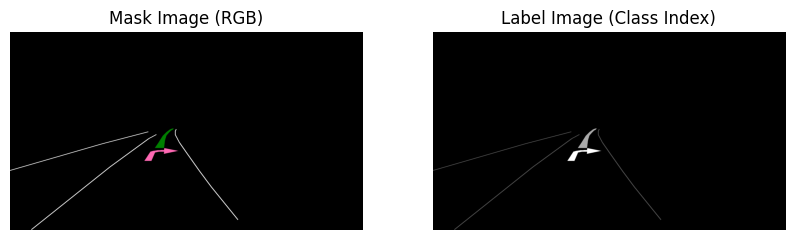

Unique class indices in the label image: [0 1 2 3]
Unique colors in the mask image: [[  0   0   0]
 [  0 128   0]
 [255 105 180]
 [255 255 255]]


In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 업로드된 이미지 파일 경로
mask_image_path = './Roadmark/Masked_Images/0101_light_clear_smooth_01000000_mask.png'
label_image_path = './Roadmark/Labels/0101_light_clear_smooth_01000000_label.png'

# 이미지 읽기
mask_image = Image.open(mask_image_path)
label_image = Image.open(label_image_path)

# 이미지 배열로 변환
mask_array = np.array(mask_image)
label_array = np.array(label_image)

# 이미지 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Mask Image (RGB)')
plt.imshow(mask_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Label Image (Class Index)')
plt.imshow(label_image, cmap='gray')
plt.axis('off')

plt.show()

# 각 클래스 인덱스 확인
unique_labels = np.unique(label_array)
print("Unique class indices in the label image:", unique_labels)

# 각 색상에 해당하는 픽셀 값 확인
unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
print("Unique colors in the mask image:", unique_colors)

#### Satellite

In [ ]:
def process_json_files(json_directory, output_directory, imcoords):
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Process each JSON file in the input directory
    for json_file in tqdm(os.listdir(json_directory)):
        if json_file.endswith(".json"):
            with open(os.path.join(json_directory, json_file)) as f:
                data = json.load(f)

            # Use the JSON file name (without extension) as image_id
            image_id = os.path.splitext(json_file)[0]

            # Create a blank mask image
            mask_image = Image.new("L", (1024, 1024), 0)
            draw = ImageDraw.Draw(mask_image)

            # Iterate over features and draw polygons on the mask image
            if imcoords:
                for feature in data['features']:
                    coords = feature['properties'].get(imcoords, 'EMPTY')
                    if coords != 'EMPTY':
                        try:
                            coords = list(map(float, coords.split(', ')))
                            coords = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
                            if len(coords) >= 2:  # Ensure there are at least two coordinate pairs
                                draw.polygon(coords, outline=1, fill=1)
                        except ValueError:
                            print(f"Invalid coordinate values in file {json_file}: {coords}")

            # Save the mask image with the JSON file name
            mask_image.save(os.path.join(output_directory, f"{image_id}_mask.png"))

In [26]:
# Input and output directories for train data
process_json_files("./Satellite_Data/Buildings/train_buildings_labels/", "./Satellite_Data/Buildings/train_buildings_masks/", imcoords = 'building_imcoords')
process_json_files("./Satellite_Data/Buildings/validate_buildings_labels/", "./Satellite_Data/Buildings/validate_buildings_masks/", imcoords = 'building_imcoords')

100%|██████████| 159/159 [00:03<00:00, 45.65it/s]


In [27]:
# Input and output directories for train data
process_json_files("./Satellite_Data/Roads/train_roads_labels/", "./Satellite_Data/Roads/train_roads_masks", imcoords = 'road_imcoords')
process_json_files("./Satellite_Data/Roads/validate_roads_labels/", "./Satellite_Data/Roads/validate_roads_masks/", imcoords = 'road_imcoords')

 23%|██▎       | 266/1144 [00:04<00:13, 64.77it/s]

Invalid coordinate values in file BLD00596_PS3_K3A_NIA0277.json: 
Invalid coordinate values in file BLD00596_PS3_K3A_NIA0277.json: 


 25%|██▌       | 286/1144 [00:04<00:15, 55.30it/s]

Invalid coordinate values in file BLD00656_PS3_K3A_NIA0277.json: 


100%|██████████| 127/127 [00:01<00:00, 63.83it/s]


## Satellite 이미지 데이터 Crop 진행

In [2]:
def split_and_save_images(original_path, mask_path, save_path_image, save_path_mask):
    # 원본 이미지와 마스크 이미지 목록 가져오기
    original_images = os.listdir(original_path)
    mask_images = os.listdir(mask_path)

    # 512x512로 이미지를 나누고 저장
    for original_image_name in tqdm(original_images):
        if original_image_name.endswith('.png'):
            original_image_path = os.path.join(original_path, original_image_name)
            mask_image_name = original_image_name.replace('.png', '_mask.png')
            mask_image_path = os.path.join(mask_path, mask_image_name)

            if os.path.exists(mask_image_path):
                original_img = Image.open(original_image_path)
                mask_img = Image.open(mask_image_path)

                # 이미지를 4등분
                for i in range(2):
                    for j in range(2):
                        left = i * 512
                        upper = j * 512
                        right = left + 512
                        lower = upper + 512

                        # 원본 이미지 저장
                        save_name = f"{original_image_name.split('.')[0]}_{i * 2 + j + 1}.png"
                        save_path_img = os.path.join(save_path_image, save_name)
                        cropped_original = original_img.crop((left, upper, right, lower))
                        cropped_original.save(save_path_img)

                        # 마스크 이미지 저장
                        save_name_mask = f"{original_image_name.split('.')[0]}_{i * 2 + j + 1}_mask.png"
                        save_path_mask_img = os.path.join(save_path_mask, save_name_mask)
                        cropped_mask = mask_img.crop((left, upper, right, lower))
                        cropped_mask.save(save_path_mask_img)

In [3]:
directories = [
        {
            "original_path": "./Satellite_Data/Buildings/train_buildings_images/",
            "mask_path": "./Satellite_Data/Buildings/train_buildings_masks/",
            "save_path_image": "./Segmentation_Data/Buildings/train_images/",
            "save_path_mask": "./Segmentation_Data/Buildings/train_masks/"
        },
        {
            "original_path": "./Satellite_Data/Buildings/validate_buildings_images/",
            "mask_path": "./Satellite_Data/Buildings/validate_buildings_masks/",
            "save_path_image": "./Segmentation_Data/Buildings/validate_images/",
            "save_path_mask": "./Segmentation_Data/Buildings/validate_masks/"
        },
        {
            "original_path": "./Satellite_Data/Roads/train_roads_images/",
            "mask_path": "./Satellite_Data/Roads/train_roads_masks/",
            "save_path_image": "./Segmentation_Data/Roads/train_images/",
            "save_path_mask": "./Segmentation_Data/Roads/train_masks/"
        },
        {
            "original_path": "./Satellite_Data/Roads/validate_roads_images/",
            "mask_path": "./Satellite_Data/Roads/validate_roads_masks/",
            "save_path_image": "./Segmentation_Data/Roads/validate_images/",
            "save_path_mask": "./Segmentation_Data/Roads/validate_masks/"
        }
    ]

In [4]:
for dir_info in directories:
    # 저장할 디렉토리가 없으면 생성
    os.makedirs(dir_info["save_path_image"], exist_ok=True)
    os.makedirs(dir_info["save_path_mask"], exist_ok=True)

    split_and_save_images(
        dir_info["original_path"],
        dir_info["mask_path"],
        dir_info["save_path_image"],
        dir_info["save_path_mask"]
    )

100%|██████████| 127/127 [01:10<00:00,  1.81it/s]


## Roadmark Data split

In [13]:
import concurrent.futures
from PIL import Image
import os
from tqdm import tqdm
import random

random_seed = 42  # You can choose any integer value
random.seed(random_seed)

# 원본 이미지와 마스크 이미지의 경로
original_image_path = "./Roadmark/IMAGE/"
mask_image_path = "./Roadmark/Labels/"

# 저장할 경로
output_image_path = "./Roadmark/image_1024x1024/"
output_mask_path = "./Roadmark/mask_1024x1024/"
os.makedirs(output_image_path, exist_ok=True)
os.makedirs(output_mask_path, exist_ok=True)

# 이미지 크기
original_size = (1920, 1080)
target_size = (1024, 1024)

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(original_image_path) if f.endswith(".png")]

# 이미지 처리 함수
def process_image(image_file):
    try:
        image_path = os.path.join(original_image_path, image_file)
        mask_file = image_file.replace(".png", "_label.png")
        mask_path = os.path.join(mask_image_path, mask_file)

        # 이미지 열기
        original_image = Image.open(image_path)
        mask_image = Image.open(mask_path)

        # 중앙에서 하단의 위치에서 crop
        left = (original_size[0] - target_size[0]) // 2
        top = (original_size[1] - target_size[1]) * 2 // 3  # 하단 1/3 위치로 조정
        right = left + target_size[0]
        bottom = top + target_size[1]

        # 이미지 crop
        cropped_image = original_image.crop((left, top, right, bottom))
        cropped_mask = mask_image.crop((left, top, right, bottom))

        # 저장할 경로 및 파일명 설정
        output_image_file = os.path.join(output_image_path, image_file)
        output_mask_file = os.path.join(output_mask_path, mask_file)

        # 이미지 저장
        cropped_image.save(output_image_file)
        cropped_mask.save(output_mask_file)
    except Exception as e:
        print(f"Failed to process {image_file}: {e}")

# 병렬 처리
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(process_image, image_files), total=len(image_files)))

100%|██████████| 37714/37714 [45:34<00:00, 13.79it/s] 


In [14]:
# 원본 이미지와 마스크 이미지가 있는 경로
img_path = "./Roadmark/image_1024x1024/"
mask_path = "./Roadmark/mask_1024x1024/"

# 분할된 데이터를 저장할 경로
train_img_dest = "./Roadmark/train/img/"
train_mask_dest = "./Roadmark/train/mask/"
valid_img_dest = "./Roadmark/valid/img/"
valid_mask_dest = "./Roadmark/valid/mask/"

# 디렉토리 생성
os.makedirs(train_img_dest, exist_ok=True)
os.makedirs(train_mask_dest, exist_ok=True)
os.makedirs(valid_img_dest, exist_ok=True)
os.makedirs(valid_mask_dest, exist_ok=True)

In [15]:
# 시드 설정
seed_value = 42
random.seed(seed_value)

# 이미지 파일 목록 가져오기
img_files = [f for f in os.listdir(img_path) if f.endswith(".png")]

# 데이터를 섞어 무작위로 나누기
random.shuffle(img_files)
split_ratio = 0.8
split_index = int(len(img_files) * split_ratio)

train_files = img_files[:split_index]
valid_files = img_files[split_index:]

In [16]:
# train 이미지 및 마스크 복사
for file in tqdm(train_files):
    img_src = os.path.join(img_path, file)
    mask_src = os.path.join(mask_path, file.replace(".png", "_label.png"))
    
    shutil.copy(img_src, train_img_dest)
    shutil.copy(mask_src, train_mask_dest)

# valid 이미지 및 마스크 복사
for file in tqdm(valid_files):
    img_src = os.path.join(img_path, file)
    mask_src = os.path.join(mask_path, file.replace(".png", "_label.png"))
    
    shutil.copy(img_src, valid_img_dest)
    shutil.copy(mask_src, valid_mask_dest)

100%|██████████| 7543/7543 [03:10<00:00, 39.61it/s]


## Data별 면적 확인

#### Buildings

In [6]:
# 마스킹 이미지가 있는 디렉토리 경로
mask_dir = "./Segmentation_Data/Buildings/train_images/"

# 디렉토리 내의 모든 파일 가져오기
mask_files = os.listdir(mask_dir)

# 객체 크기를 저장할 리스트
object_sizes = []

# 모든 마스크 이미지에 대해 반복
for mask_file in tqdm(mask_files):
    # 이미지 읽기
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 객체 감지 (흰색 영역)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 객체 크기 측정 및 저장
    for contour in contours:
        object_size = cv2.contourArea(contour)
        object_sizes.append(object_size)

  0%|          | 0/4952 [00:00<?, ?it/s]

100%|██████████| 4952/4952 [01:15<00:00, 65.27it/s]


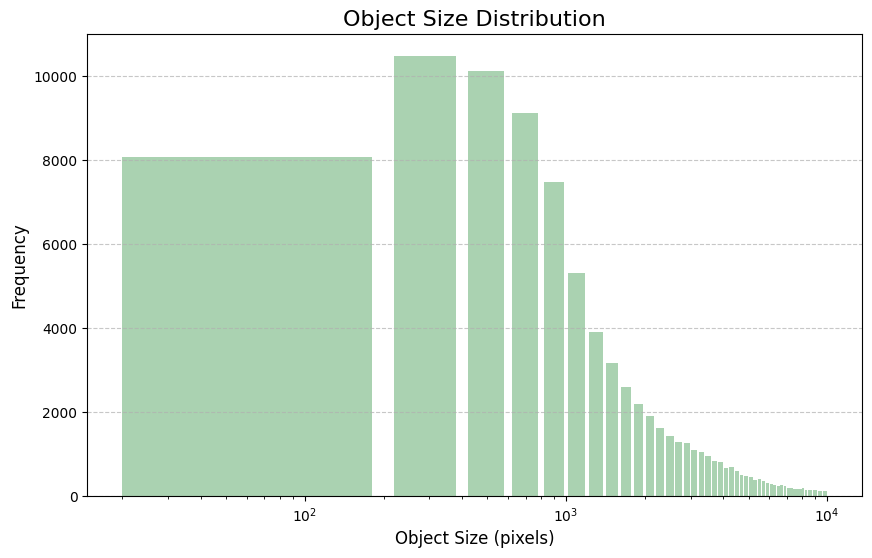

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(object_sizes, bins=50, range=(0, 10000), color='#86bf91', rwidth=0.8, alpha=0.7)
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

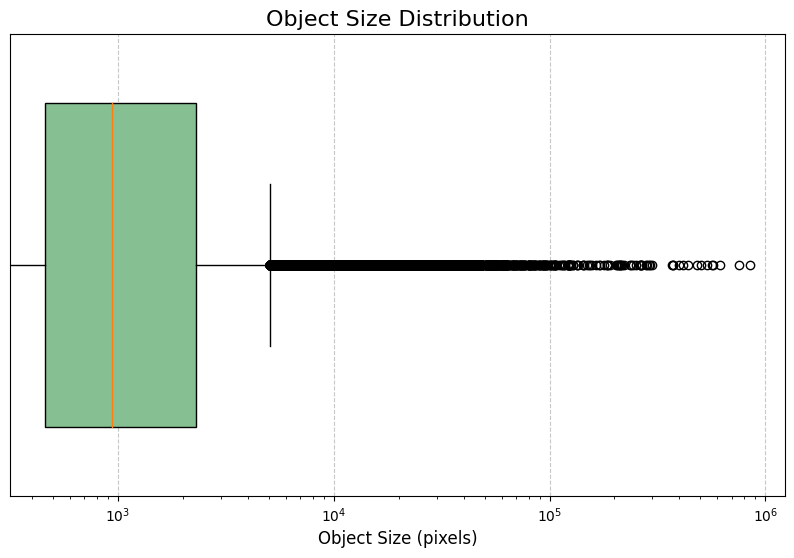

In [40]:
plt.figure(figsize=(10, 6))
plt.boxplot(object_sizes, vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='#86bf91', color='black'))
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.yticks([])
plt.xticks(fontsize=10)
plt.show()

#### Roads

In [41]:
# 마스킹 이미지가 있는 디렉토리 경로
mask_dir = "./Satellite_Data/Roads/train_roads_masks"

# 디렉토리 내의 모든 파일 가져오기
mask_files = os.listdir(mask_dir)

# 객체 크기를 저장할 리스트
object_sizes = []

# 모든 마스크 이미지에 대해 반복
for mask_file in tqdm(mask_files):
    # 이미지 읽기
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 객체 감지 (흰색 영역)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 객체 크기 측정 및 저장
    for contour in contours:
        object_size = cv2.contourArea(contour)
        object_sizes.append(object_size)

100%|██████████| 1144/1144 [00:04<00:00, 230.98it/s]


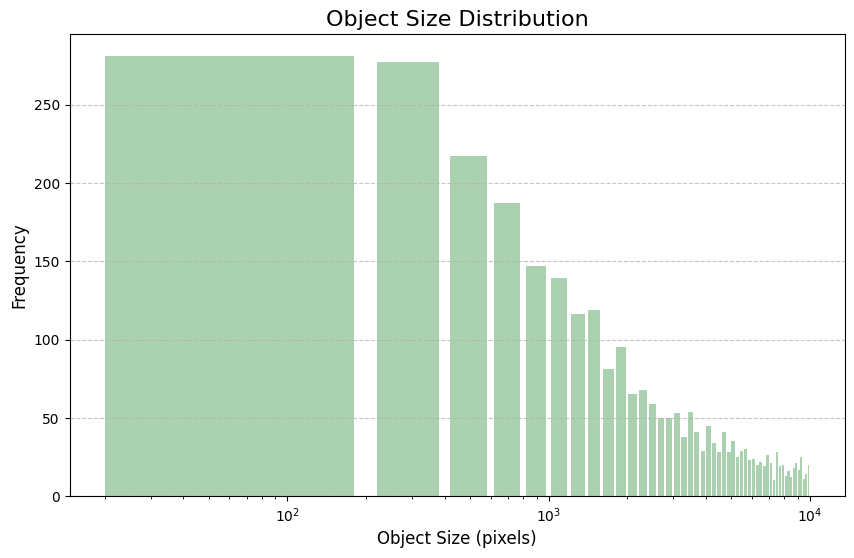

In [42]:
plt.figure(figsize=(10, 6))
plt.hist(object_sizes, bins=50, range=(0, 10000), color='#86bf91', rwidth=0.8, alpha=0.7)
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

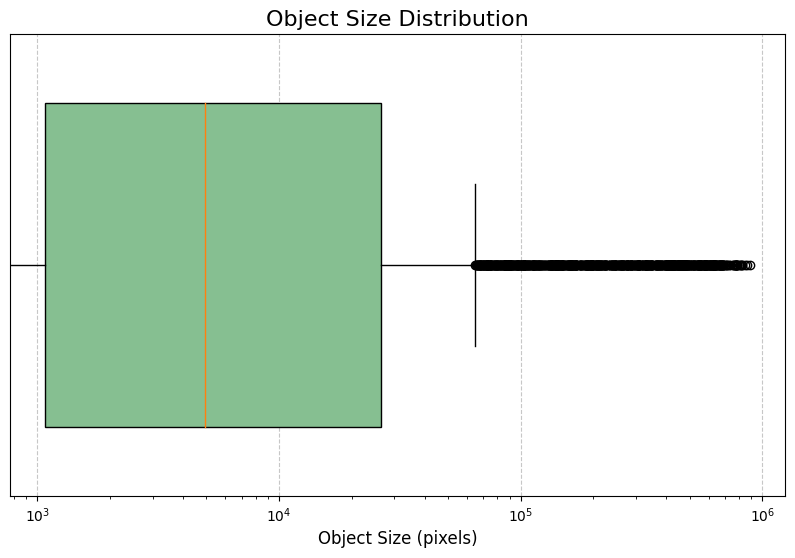

In [43]:
plt.figure(figsize=(10, 6))
plt.boxplot(object_sizes, vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='#86bf91', color='black'))
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.yticks([])
plt.xticks(fontsize=10)
plt.show()

## MMSegmentation 결과 확인

In [2]:
%cd mmsegmentation
import mmseg
print(mmseg.__version__)

c:\python_code\Segmentation_project\mmsegmentation
1.2.2


In [3]:
from mmseg.apis import MMSegInferencer
models = MMSegInferencer.list_models('mmseg')

07/19 20:51:05 - mmengine - INFO - model_name: ann_r50-d8_4xb2-40k_cityscapes-512x1024
model_name: ann_r101-d8_4xb2-40k_cityscapes-512x1024
model_name: ann_r50-d8_4xb2-40k_cityscapes-769x769
model_name: ann_r101-d8_4xb2-40k_cityscapes-769x769
model_name: ann_r50-d8_4xb2-80k_cityscapes-512x1024
model_name: ann_r101-d8_4xb2-80k_cityscapes-512x1024
model_name: ann_r50-d8_4xb2-80k_cityscapes-769x769
model_name: ann_r101-d8_4xb2-80k_cityscapes-769x769
model_name: ann_r50-d8_4xb4-80k_ade20k-512x512
model_name: ann_r101-d8_4xb4-80k_ade20k-512x512
model_name: ann_r50-d8_4xb4-160k_ade20k-512x512
model_name: ann_r101-d8_4xb4-160k_ade20k-512x512
model_name: ann_r50-d8_4xb4-20k_voc12aug-512x512
model_name: ann_r101-d8_4xb4-20k_voc12aug-512x512
model_name: ann_r50-d8_4xb4-40k_voc12aug-512x512
model_name: ann_r101-d8_4xb4-40k_voc12aug-512x512
model_name: apcnet_r50-d8_4xb2-40k_cityscapes-512x1024
model_name: apcnet_r101-d8_4xb2-40k_cityscapes-512x1024
model_name: apcnet_r50-d8_4xb2-40k_cityscapes-76

In [4]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

img_path = 'C:/python_code/Segmentation_project/Roadmark/valid/img/0101_light_clear_smooth_01000006.png'

config_file = f'./work_dirs/pidnet-s_2xb6-120k_512x512-roadmark/pidnet-s_2xb6-120k_512x512-roadmark.py'
checkpoint_file = f'./work_dirs/pidnet-s_2xb6-120k_512x512-roadmark/iter_250000.pth'

# build the model from a config file and a checkpoint file
model = init_model(config_file, checkpoint_file, device='cuda:0')

# inference on given image
result = inference_model(model, img_path)

# save the visualization result, the output image would be found at the path `work_dirs/result.png`
vis_iamge = show_result_pyplot(model, img_path, result, out_file= f'work_dirs/result_roadmark.png')

c:\python_code\Segmentation_project\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/pidnet-s_2xb6-120k_512x512-roadmark/iter_250000.pth


c:\python_code\Segmentation_project\mmsegmentation\mmseg\models\utils\wrappers.py:22: UserWarning: When align_corners=True, the output would more aligned if input size (64, 64) is `x+1` and out size (512, 512) is `nx+1`
  warnings.warn(
c:\Users\coden\anaconda3\envs\openmmlab\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
